In [ ]:
## Install Libraries
%%capture
! pip install transformers
! pip install accelerate -U
! pip install --upgrade tensorflow
! pip install datasets
! pip install huggingface_hub




In [ ]:

## Load Libraries
%%capture
##for data handling
import pandas as pd
import numpy  as np
import os

##visualizations
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns


#NLP
import re
import nltk
from collections import Counter


In [ ]:
## Load data
from google.colab import drive

In [ ]:
mount_point = "/content/drive/MyDrive/Sentiment analysis"
if not os.path.exists(mount_point):
    os.makedirs(mount_point)


In [ ]:
## Load datasets
Train_path="/content/drive/MyDrive/Sentiment analysis/Train.csv"
test_path="/content/drive/MyDrive/Sentiment analysis/Test.csv"

In [ ]:
##Read datasets
df_train=pd.read_csv(Train_path)
df_test=pd.read_csv(test_path)

In [ ]:
#view train and test data
df_train.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [ ]:
df_test.head()

,tweet_id,safe_text
0,00BHHHP1,<user> <user> ... &amp; 4 a vaccine given 2 he...
1,00UNMD0E,Students starting school without whooping coug...
2,01AXPTJF,"I'm kinda over every ep of <user> being ""rippe..."
3,01HOEQJW,How many innocent children die for lack of vac...
4,01JUKMAO,"CDC eyeing bird flu vaccine for humans, though..."


In [ ]:
##create a copy incase of any setback
train_data=df_train.copy()
test_data=df_test.copy()

## CRISP-DM Framework

- Data Understanding
- Data Preparation
- Modelling
- Evaluation
- Deployment

## 1.Data Understanding

Here we will do the following:
- Check the info of the dataset
- Check for missing values
- Check for duplicates
- Plot some charts if necessary

# 1.1 Checking Info

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   10001 non-null  object 
 1   safe_text  10001 non-null  object 
 2   label      10000 non-null  float64
 3   agreement  9999 non-null   float64
dtypes: float64(2), object(2)
memory usage: 312.7+ KB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5177 entries, 0 to 5176
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   5177 non-null   object
 1   safe_text  5176 non-null   object
dtypes: object(2)
memory usage: 81.0+ KB


Let's rename the safe_text to tweets to make it more understandable


In [ ]:
##renaming safe_text column
df_train.rename(columns= {"safe_text": "tweets"}, inplace= True)
df_test.rename(columns= {"safe_text": "tweets"}, inplace= True)

In [ ]:
##view changes
df_train.columns ,df_test.columns

(Index(['tweet_id', 'tweets', 'label', 'agreement'], dtype='object'),
 Index(['tweet_id', 'tweets'], dtype='object'))

# 1.2 Check for missing values

In [ ]:
#we check for missing values in train data
df_train.isnull().sum()

tweet_id     0
tweets       0
label        1
agreement    2
dtype: int64

In [ ]:
#view missing values in label and agreement column for train data
df_train[df_train["label"].isnull()]
df_train[df_train["agreement"].isnull()]

,tweet_id,tweets,label,agreement
4798,RQMQ0L2A,#lawandorderSVU,NaN,NaN
4799,I cannot believe in this day and age some pare...,1,0.666667,NaN


In [ ]:
#check for missing values in test data
df_test.isnull().sum()

tweet_id    0
tweets      1
dtype: int64

In [ ]:
#view missing values in tweets column
df_test[df_test["tweets"].isna()]

,tweet_id,tweets
2024,Dr. JAMES SHANNON,NaN


## Notes after checking for missing values:
We will drop them in the Data Preparation stage

# 1.3 Checking for duplicates

In [ ]:
df_train.duplicated().sum(),df_test.duplicated().sum()

(0, 0)

- There were no duplicates

# 1.4 Visualizations

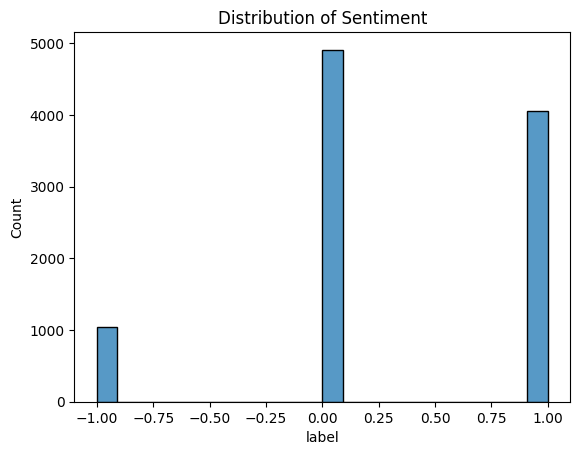

In [ ]:
#Using seaborn
sns.histplot(data=df_train, x="label")

# Set the title using Matplotlib
plt.title("Distribution of Sentiment")

# Display the plot
plt.show()

Notes:

- Most tweets were neutral
- There were more postive tweets than negative
- There is class imbalance


In [ ]:
#checking the number of unique values in label class
df_train["label"].unique()


array([ 0.        ,  1.        , -1.        ,         nan,  0.66666667])

In [ ]:
## we assign 1 to positive, 0 to neutral and -1 to negative for the label

postive= df_train[df_train["label"]== 1]


negative= df_train[df_train["label"]== -1]


neutral= df_train[df_train["label"]== 0]

In [ ]:
#view any class to see if changes were applied
postive.head()

,tweet_id,tweets,label,agreement
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.000000
5,OVNPOAUX,<user> a nearly 67 year old study when mental ...,1.0,0.666667
6,JDA2QDV5,"Study of more than 95,000 kids finds no link b...",1.0,0.666667
7,S6UKR4OJ,psa: VACCINATE YOUR FUCKING KIDS,1.0,1.000000
8,V6IJATBE,Coughing extra on the shuttle and everyone thi...,1.0,0.666667


In [ ]:
### we add a column tweet_length to see length of tweet
df_train["tweet_length"]=[len(i.split(" "))for i in df_train["tweets"]]

In [ ]:
## view train data after changes
df_train.head()

,tweet_id,tweets,label,agreement,tweet_length
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0,15
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0,25
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0,7
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0,28
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0,20


In [ ]:
##let's see the maximum lenth of the tweets
df_train["tweet_length"].max()

33

In [ ]:
# Get the value counts of tweet_length
tweet_length_value_counts = df_train['tweet_length'].value_counts().reset_index()
tweet_length_value_counts.columns = ['tweet_length', 'count']


In [ ]:
#using plotly
fig= px.scatter(data_frame= tweet_length_value_counts, x= "tweet_length", y= "count", size= "count", color= "tweet_length", title= "Length of Tweets")

fig.show()

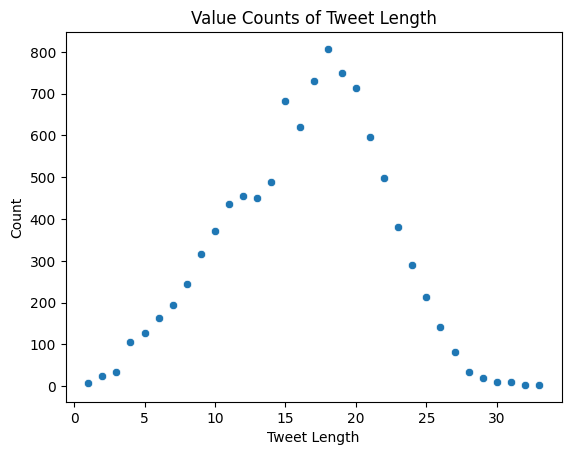

In [ ]:
##For visual to show on git hub

# Create a scatter plot
sns.scatterplot(data=tweet_length_value_counts, x='tweet_length', y='count')

# Set labels and title
plt.xlabel("Tweet Length")
plt.ylabel("Count")
plt.title("Value Counts of Tweet Length")

# Show the plot
plt.show()

Notes
- Most tweet are 18 words of length

# 2 Data Preparation
In this section we will:
- Handle Missing values
- Drop irrelevant columns
-Perfrom some NLP techniques like tokenization,stemming or Lemitization etc


## 2.1 Handling Missing values

Earlier on,we reaslised the amount of missing values are just a few so we will just drop them

In [ ]:
##dropping missing values
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [ ]:
## view changes
df_train.isnull().sum()

tweet_id        0
tweets          0
label           0
agreement       0
tweet_length    0
dtype: int64

In [ ]:
df_test.isnull().sum()

tweet_id    0
tweets      0
dtype: int64

## 2.2 Dropping Irrelevant columns
- Here the tweet_id column will be dropped since it will not be relevant to our analysis


In [ ]:
##drop irrelevant column
df_train=df_train.drop("tweet_id",axis=1)

df_test=df_test.drop("tweet_id",axis=1)

In [ ]:
## view to check changes applied
df_train.columns

Index(['tweets', 'label', 'agreement', 'tweet_length'], dtype='object')

In [ ]:
df_test.columns

Index(['tweets'], dtype='object')

# 2.3 Using NLP Preprocessing Techniques

## 1. Convert all the texts to lowercase


In [ ]:
df_train["tweets"]=df_train["tweets"].str.lower()
df_test["tweets"]=df_test["tweets"].str.lower()

## 2. Remove Special Characters





In [ ]:
def remove_characters(characters):
  #remove special chracters
  characters=re.sub(r'#\w+', '', characters)
  ##removing punctuations
  characters= re.sub("[^\w\s]",  "", characters)
  return characters

In [ ]:
## view special characters in train
df_train["tweets"]

0        me &amp; the big homie meanboy3000 #meanboy #m...
1        i'm 100% thinking of devoting my career to pro...
2        #whatcausesautism vaccines, do not vaccinate y...
3        i mean if they immunize my kid with something ...
4        thanks to <user> catch me performing at la nui...
                               ...                        
9996     living in a time where the sperm i used to was...
9997     <user> <user>  in spite of all measles outbrea...
9998     interesting trends in child immunization in ok...
9999     cdc says measles are at highest levels in deca...
10000    pneumonia vaccine: for women w risk of pulmona...
Name: tweets, Length: 9999, dtype: object

In [ ]:
# Apply the function to df_train
df_train["tweets"] = df_train["tweets"].apply(remove_characters)

# Apply the function to df_test
df_test["tweets"] = df_test["tweets"].apply(remove_characters)

In [ ]:
#view changes
df_train["tweets"]

0        me amp the big homie meanboy3000       stegman...
1        im 100 thinking of devoting my career to provi...
2                     vaccines do not vaccinate your child
3        i mean if they immunize my kid with something ...
4        thanks to user catch me performing at la nuit ...
                               ...                        
9996     living in a time where the sperm i used to was...
9997     user user  in spite of all measles outbreaks j...
9998     interesting trends in child immunization in ok...
9999     cdc says measles are at highest levels in deca...
10000    pneumonia vaccine for women w risk of pulmonar...
Name: tweets, Length: 9999, dtype: object

In [ ]:
##view full train datset
df_train.head()

,tweets,label,agreement,tweet_length
0,me amp the big homie meanboy3000 stegman...,0.0,1.0,15
1,im 100 thinking of devoting my career to provi...,1.0,1.0,25
2,vaccines do not vaccinate your child,-1.0,1.0,7
3,i mean if they immunize my kid with something ...,-1.0,1.0,28
4,thanks to user catch me performing at la nuit ...,0.0,1.0,20


## 3 Removing Unnecessary words

In [ ]:
#count word frequencies
word_counts = Counter(" ".join(df_train["tweets"]).split())

# Get the most common words and their frequencies
most_common_words = word_counts.most_common()

# Print the top N most frequent words
N = 10  # Change N to the desired number of top words
for word, count in most_common_words[:N]:
    print(f"{word}: {count}")

user: 5499
url: 4630
the: 4118
to: 3636
measles: 3176
a: 2453
of: 2354
in: 2172
and: 1993
i: 1705


- Even tho user and url are the most frequent words,they are irrelevant so we will remove them
- Remove numbers





In [ ]:
#removing url and user word
def remove_words(text, words_to_remove):
    words = text.split()
    # Remove specified words
    filtered_words = [word for word in words if word not in words_to_remove]
    # Join the filtered words back into a string
    filtered_text = " ".join(filtered_words)
    return filtered_text

# Define the words to remove
words_to_remove = ["user", "url"]

# Apply the remove_words function to the "tweets" column
df_train["tweets"] = df_train["tweets"].apply(lambda x: remove_words(x, words_to_remove))
df_test["tweets"] = df_test["tweets"].apply(lambda x: remove_words(x, words_to_remove))


In [ ]:
#remove numbers
def number_remover(text):
  text= re.sub(r'\d+', '', text)
  return " ".join([word for word in text.split() if not word.isdigit()])


In [ ]:
#Apply to train and test
df_train["tweets"]= df_train["tweets"].apply(number_remover)
df_test["tweets"]=df_test["tweets"].apply(number_remover)


After removing the numbers and the user we now want to know our new most frequent words




In [ ]:
# Count word frequencies
word_counts = Counter(" ".join(df_train["tweets"]).split())

# Get the most common words and their frequencies
most_common_words = word_counts.most_common()

# Print the top N most frequent words
N = 10  # Change N to the desired number of top words

# Create a list of dictionaries
top_words_list = [{"Word": word, "Frequency": count} for word, count in most_common_words[:N]]

# Convert the list to a DataFrame
top_words_df = pd.DataFrame(top_words_list)


top_words_df


,Word,Frequency
0,the,4120
1,to,3637
2,measles,3177
3,a,2465
4,of,2355
5,in,2174
6,and,1993
7,i,1706
8,is,1615
9,for,1610


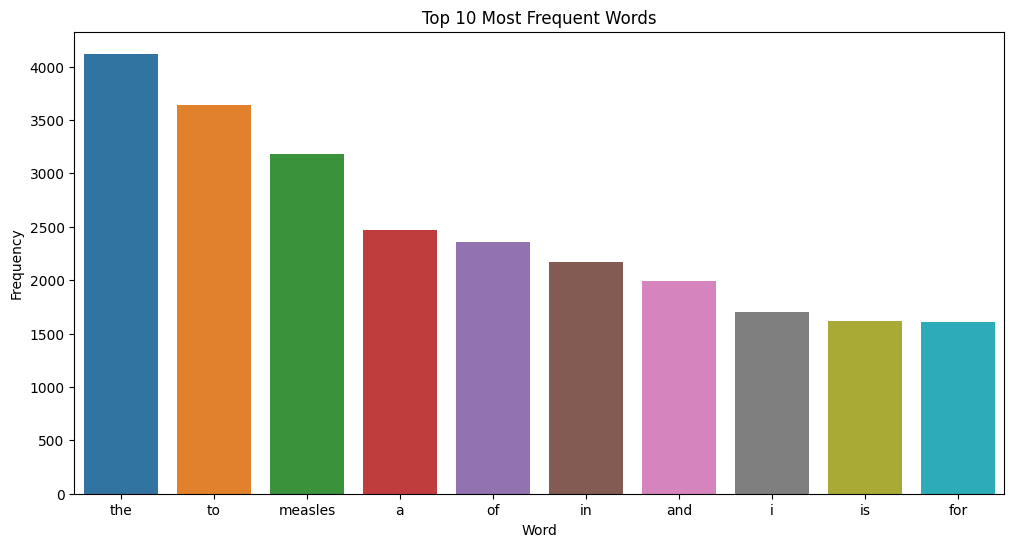

In [ ]:
### Visualise most frequent words

#Create a countplot
plt.figure(figsize=(12, 6))  # Set the figure size

# Use the top_words_df DataFrame for visualization
plot = sns.barplot(x="Word", y="Frequency", data=top_words_df)

plt.title(f"Top {N} Most Frequent Words")
plt.show()

## 4.Feature Engineering
- filter out the most important columns from our train dataframe
- Perform feature engineering

In [ ]:
#view train data
df_train.head()

,tweets,label,agreement,tweet_length
0,me amp the big homie meanboy stegman st,0.0,1.0,15
1,im thinking of devoting my career to proving a...,1.0,1.0,25
2,vaccines do not vaccinate your child,-1.0,1.0,7
3,i mean if they immunize my kid with something ...,-1.0,1.0,28
4,thanks to catch me performing at la nuit nyc s...,0.0,1.0,20


In [ ]:
#we create a new dataframe for our clean data
clean_train_data=df_train[["tweets","label","agreement"]]

In [ ]:
#view clean data
clean_train_data.head()

,tweets,label,agreement
0,me amp the big homie meanboy stegman st,0.0,1.0
1,im thinking of devoting my career to proving a...,1.0,1.0
2,vaccines do not vaccinate your child,-1.0,1.0
3,i mean if they immunize my kid with something ...,-1.0,1.0
4,thanks to catch me performing at la nuit nyc s...,0.0,1.0


In [ ]:
#save clean data to csv
clean_train_data.to_csv("/content/drive/MyDrive/Sentiment analysis/clean_data.csv")
